# Homework 3: Sequence prediction - letters and numbers.

# Import libraries

In [ ]:
# import all necessary libs
import numpy as np
from numpy import array
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline


import json
import random


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras.layers import Dense


import os
import sys
sys.set_int_max_str_digits(int(10E6)) 

In [ ]:
import numpy as np
from nltk.tokenize import RegexpTokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers.core import Dense, Activation
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq

Import data

In [ ]:
os.chdir('/content/drive/MyDrive/Colab Files/UNIVAQ_codes/Advance_ML_Techniques/seq-pred')

!ls

Italia-positivi-giornaliero.csv
Italia-positivi-giornaliero.gsheet
Italia-trend-giornaliero.csv
Italia-trend-giornaliero.gsheet
MobyDick.txt
pi1000000.txt
pi.csv
pi.gsheet
seq_prediction.ipynb
seq_prediction_text_Natural_Language_Processing.ipynb
seq_prediction_v2.ipynb
TotalPositiveVariation.csv
TotalPositiveVariation.gsheet


In [ ]:
ls

 Volume in drive C has no label.
 Volume Serial Number is F952-AB20

 Directory of C:\Users\USER\OneDrive - Universita' degli Studi dell'Aquila\UNIVAQ\Yr2\SEM 1\ML Techniques\seq_pred_RNN

09/01/2023  17:56    <DIR>          .
09/01/2023  17:56    <DIR>          ..
09/01/2023  16:46    <DIR>          .ipynb_checkpoints
09/01/2023  16:45           607,791 1661-0.txt
09/01/2023  17:20               148 history.p
04/01/2023  01:54             4,172 Italia-positivi-giornaliero.csv
04/01/2023  01:54         1,276,235 MobyDick.txt
09/01/2023  17:20        48,547,864 next_word_model.h5
08/01/2023  01:46         1,000,003 pi.csv
09/01/2023  17:56         2,861,892 seq_prediction_text_Natural_Language_Processing_v2.ipynb
               7 File(s)     54,298,105 bytes
               3 Dir(s)  173,984,653,312 bytes free


# MLP

## A. Covid data & MLP

### Design and code a panel of k predictors of the type Ψ(M,1) with an MLP, each constructed and trained to predict one symbol of the sequence future, taking as input M symbols of the sequence past.

In [ ]:
data = pd.read_csv('Italia-positivi-giornaliero.csv')

Text(0.5, 1.0, 'Italia Positivi Giornaliero')

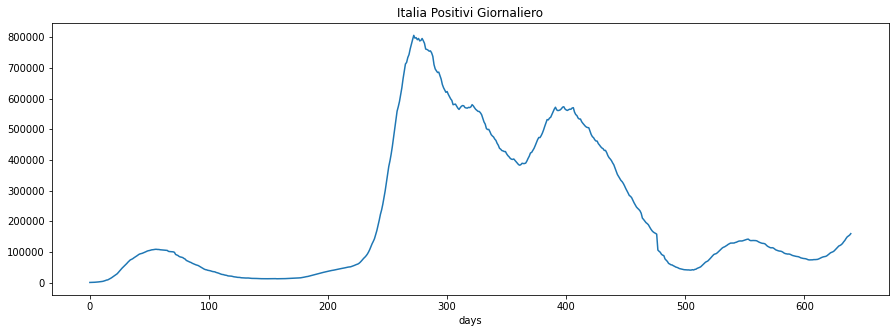

In [ ]:
plt.figure(figsize = (15, 5))
plt.plot(data)
plt.xlabel("days")
plt.title('Italia Positivi Giornaliero')

In [ ]:
data.shape, data.iloc[-1]

((640, 1), totale_positivi    159317
 Name: 639, dtype: int64)

In [ ]:
data_list = array(data.totale_positivi.values.tolist())

In [ ]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
split_data = []

i = 1
predictors = 20 # number of  predictors
start = predictors 
seq = np.arange(start)
while i > 0 and start > 0:
    # print( "start: {}, i: {}, data:{}" .format(start, i, data_list[ start-1: -i] ) )
    split_data.append(data_list[ start-1: -i])
    i+=1
    start-=1

In [ ]:
# define input sequence
seq = np.arange(predictors)
output_k_predictors = [] # list to save the final output of the k predictors.

In [ ]:
# seq

In [ ]:
split_data[0].shape

(620,)

In [ ]:
for i in seq:
    raw_seq = split_data[i]
    # choose a number of time steps
    n_steps_in, n_steps_out = 20, i + 1
    # split into samples
    X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
    # define model
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=n_steps_in))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    # fit model
    model.fit(X, y, epochs=2000, verbose=0)
    # demonstrate prediction
    x_input = split_data[i][-n_steps_in:]
    x_input = x_input.reshape((1, n_steps_in))
    yhat = model.predict(x_input, verbose=0)
    
    output_k_predictors.append(yhat[-1][-1])

In [ ]:
output_k_predictors

[157952.58,
 157438.28,
 161134.1,
 156805.98,
 154037.45,
 162576.4,
 149790.53,
 146908.97,
 159029.84,
 164863.73,
 161615.47,
 150604.42,
 157206.9,
 143512.23,
 150112.8,
 149736.05,
 138501.56,
 125572.414,
 120415.03,
 113627.77]

In [ ]:
np.mean(output_k_predictors)

149072.12

### Create, code, and train a deep model, a new MLP layer that takes as input the k predictions of your predictors and outputs one symbol. 

In [ ]:
# define input sequence
raw_seq = sorted(output_k_predictors) # sorting to accomodate subsequent drop in accuracy
# choose a number of time steps
n_steps_in, n_steps_out = 3,  1
# split into samples
X, y = split_sequence(raw_seq,  n_steps_in, n_steps_out)
# define model
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=n_steps_in))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=2000, verbose=0)

In [ ]:
# demonstrate prediction
x_input = np.array(sorted(output_k_predictors)[-3:])
x_input = x_input.reshape((1, n_steps_in))
yhat_k_predictors_covid_mlp = model.predict(x_input, verbose=0)
print(yhat_k_predictors_covid_mlp)

[[167805.83]]


### Visualization of Results

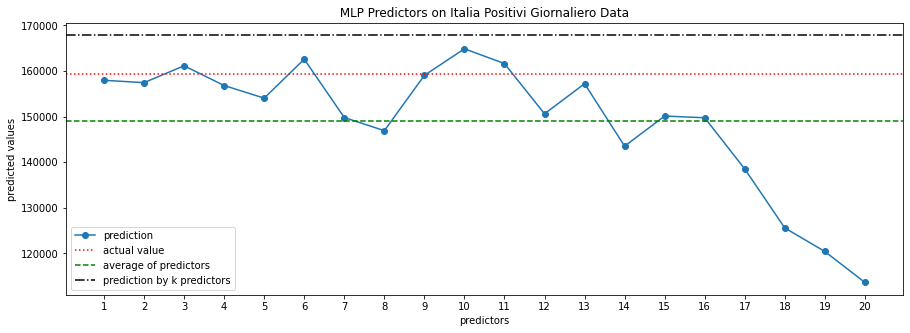

In [ ]:
plt.figure(figsize = (15, 5))
plt.plot(output_k_predictors, label = 'prediction', marker = 'o' )
# specifying horizontal line type
plt.axhline(y = data_list[-1], color = 'r', linestyle = 'dotted', label = 'actual value');
plt.axhline(np.mean(output_k_predictors), color = 'g', linestyle = 'dashed',\
            label = 'average of predictors');
plt.axhline(yhat_k_predictors_covid_mlp, color = 'black', linestyle = 'dashdot',\
            label = 'prediction by k predictors');

# define ticks
xticks = [str(i + 1) for i in range(20)]
plt.xticks(np.arange(0, 20), xticks);
plt.legend()
plt.ylabel('predicted values')
plt.xlabel('predictors')
plt.title(" MLP Predictors on Italia Positivi Giornaliero Data ");

## B. Pi data & MLP

In [ ]:
with open('pi1000000.txt') as f:
    pi = f.readlines()

In [ ]:
pi = np.array(pi)

In [ ]:
pi = pi[0][2:] # remove "3."

In [ ]:
pi

'141592653589793238462643383279502884197169399375105820974944592307816406286208998628034825342117067982148086513282306647093844609550582231725359408128481117450284102701938521105559644622948954930381964428810975665933446128475648233786783165271201909145648566923460348610454326648213393607260249141273724587006606315588174881520920962829254091715364367892590360011330530548820466521384146951941511609433057270365759591953092186117381932611793105118548074462379962749567351885752724891227938183011949129833673362440656643086021394946395224737190702179860943702770539217176293176752384674818467669405132000568127145263560827785771342757789609173637178721468440901224953430146549585371050792279689258923542019956112129021960864034418159813629774771309960518707211349999998372978049951059731732816096318595024459455346908302642522308253344685035261931188171010003137838752886587533208381420617177669147303598253490428755468731159562863882353787593751957781857780532171226806613001927876611195909216420198

In [ ]:
pi = int(pi)
pi = str(pi)

In [ ]:
pi = np.array([ int(i) for i in pi ])
len(pi)

1000000

In [ ]:
pi = pi.flatten()

In [ ]:
pi.shape

(1000000,)

Text(0.5, 1.0, 'Evolution of pi digits')

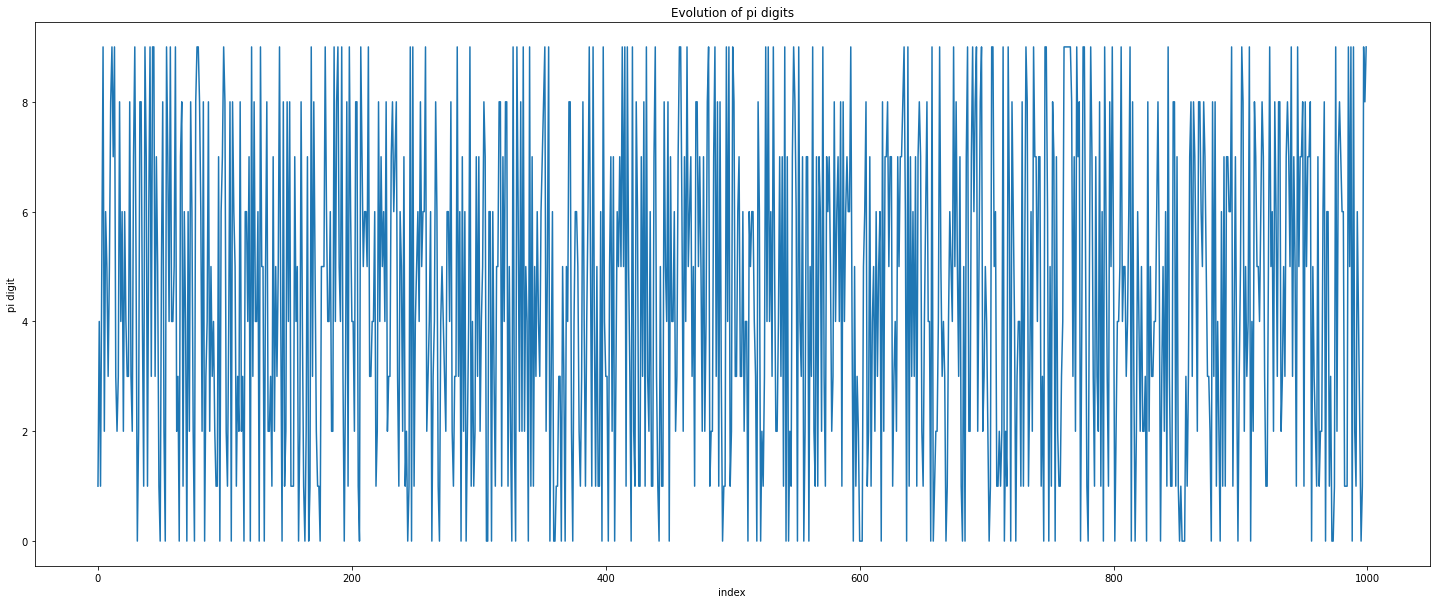

In [ ]:
plt.figure(figsize = (25, 10))
plt.plot(pi[:1000]);
plt.xlabel("index")
plt.ylabel("pi digit")
plt.title("Evolution of pi digits")

In [ ]:
def split_array(data_array, predictors = 20):
    """ Function that splits an array accordingly to the expected number of predictors """
    split_data = []

    # define input sequence
    seq = np.arange(predictors)

    i = 1
    # predictors = 15 # number of  predictors
    start = predictors 
    seq = np.arange(start)
    
    while i > 0 and start > 0:
        # print( "start: {}, i: {}, data:{}" .format(start, i, data_array[ start-1: -i] ) )
        split_data.append(data_array[ start-1: -i])
        i+=1
        start-=1

    return split_data, seq

In [ ]:
pi[:1000][-1]

9

In [ ]:
split_data, seq = split_array(pi[:1000])
split_data = np.array(split_data)
split_data.shape

(20, 980)

In [ ]:
output_k_predictors_mlp_pi = [] # list to save the final output of the k predictors.

In [ ]:
for i in seq:
    raw_seq = split_data[i]
    # choose a number of time steps
    n_steps_in, n_steps_out = 20, i + 1
    # split into samples
    X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
    # define model
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=n_steps_in))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    # fit model
    model.fit(X, y, epochs=2000, verbose=0)
    # demonstrate prediction
    x_input = split_data[i][-n_steps_in:]
    x_input = x_input.reshape((1, n_steps_in))
    yhat = model.predict(x_input, verbose=0)
    
    output_k_predictors_mlp_pi.append(yhat[-1][-1])

In [ ]:
output_k_predictors_mlp_pi

[-1.1066616,
 -1.5665332,
 9.172533,
 -7.1647196,
 1.0613979,
 3.6063633,
 5.752186,
 2.1855931,
 2.2530272,
 3.3003106,
 3.8387978,
 2.0273468,
 6.2410927,
 7.840364,
 3.9061062,
 5.737084,
 5.7364664,
 4.9214873,
 4.734086,
 5.2463717]

In [ ]:
np.mean(output_k_predictors_mlp_pi)

3.3861346

### Create, code, and train a deep model, a new MLP layer that takes as input the k predictions of your predictors and outputs one symbol. 

In [ ]:
# define input sequence
raw_seq = sorted(output_k_predictors_mlp_pi)
# raw_seq = output_k_predictors_mlp_pi
# choose a number of time steps
n_steps_in, n_steps_out = 3,  1
# split into samples
X, y = split_sequence(raw_seq,  n_steps_in, n_steps_out)
# define model
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=n_steps_in))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=2000, verbose=0)

In [ ]:
# demonstrate prediction
x_input = np.array(sorted(output_k_predictors_mlp_pi)[-3:])
# x_input = np.array(output_k_predictors_mlp_pi[-3:])
x_input = x_input.reshape((1, n_steps_in))
yhat_k_predictors_pi_mlp = model.predict(x_input, verbose=0)
print(yhat_k_predictors_pi_mlp)

[[9.781219]]


### Visualization of Results

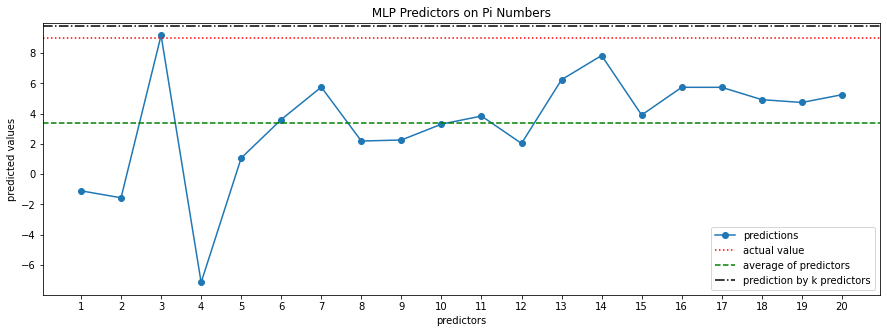

In [ ]:
plt.figure(figsize = (15, 5))
plt.plot(output_k_predictors_mlp_pi, label = 'predictions', marker = 'o' )
# specifying horizontal line type
plt.axhline(y = pi[:1000][-1], color = 'r', linestyle = 'dotted', label = 'actual value');
plt.axhline(np.mean(output_k_predictors_mlp_pi), color = 'g', linestyle = 'dashed',\
            label = 'average of predictors');
plt.axhline(yhat_k_predictors_pi_mlp, color = 'black', linestyle = 'dashdot',\
            label = 'prediction by k predictors');
plt.legend()
plt.ylabel('predicted values')
plt.xlabel('predictors')
plt.title(" MLP Predictors on Pi Numbers ")
# define ticks
xticks = [str(i + 1) for i in range(20)]
plt.xticks(np.arange(0, 20), xticks);

# LSTM

## A. Pi data & LSTM

In [ ]:
split_data_pi = split_data[:]
split_data_pi

array([[6, 2, 6, ..., 1, 9, 8],
       [4, 6, 2, ..., 0, 1, 9],
       [8, 4, 6, ..., 2, 0, 1],
       ...,
       [1, 5, 9, ..., 7, 6, 6],
       [4, 1, 5, ..., 8, 7, 6],
       [1, 4, 1, ..., 7, 8, 7]])

In [ ]:
output_k_predictors_lstm_pi = [] # list to save the final output of the k predictors.

In [ ]:
for i in seq:
    raw_seq = split_data_pi[i]
    # choose a number of time steps
    n_steps_in, n_steps_out = 20, i + 1
    # split into samples
    X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    n_features = 1
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    # define model
    # define model
    model = tf.keras.Sequential()
    model.add(layers.LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
    model.add(layers.Dense(n_steps_out))
    model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss='mse',
              metrics=[tf.keras.losses.MeanSquaredError()])
    # fit model
    model.fit(X, y, epochs=500, verbose=0)
    # demonstrate prediction
    x_input = split_data_pi[i][-n_steps_in:]
    x_input = x_input.reshape((1, n_steps_in, n_features))
    yhat = model.predict(x_input, verbose=0)
    
    output_k_predictors_lstm_pi.append(yhat[-1][-1])

In [ ]:
output_k_predictors_lstm_pi 

[4.4166756,
 5.8683395,
 4.5105414,
 3.6308358,
 1.3174238,
 4.6292167,
 3.7577958,
 7.0952597,
 5.314863,
 2.2720518,
 2.4782605,
 4.220132,
 -4.747323,
 4.354213,
 5.5086637,
 4.429779,
 5.554387,
 5.567603,
 4.765005,
 5.0231156]

In [ ]:
# [x for x in lst if x > 0]

In [ ]:
# take out only the positive values
output_k_predictors_lstm_pi_positive = [i for i in output_k_predictors_lstm_pi if i > 0]
output_k_predictors_lstm_pi_positive

[4.4166756,
 5.8683395,
 4.5105414,
 3.6308358,
 1.3174238,
 4.6292167,
 3.7577958,
 7.0952597,
 5.314863,
 2.2720518,
 2.4782605,
 4.220132,
 4.354213,
 5.5086637,
 4.429779,
 5.554387,
 5.567603,
 4.765005,
 5.0231156]

In [ ]:
np.mean([i for i in output_k_predictors_lstm_pi_positive if i > 0])

4.45864

### Create, code, and train a deep model, a new LSTM layer that takes as input the k predictions of your predictors and outputs one symbol. 

In [ ]:
# define input sequence
# raw_seq = sorted(output_k_predictors_lstm_pi_positive)
raw_seq = output_k_predictors_lstm_pi
# choose a number of time steps
n_steps_in, n_steps_out = 3,  1
# split into samples
X, y = split_sequence(raw_seq,  n_steps_in, n_steps_out)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = tf.keras.Sequential()
model.add(layers.LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(layers.Dense(n_steps_out))

model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss='mse',
              metrics=[tf.keras.losses.MeanSquaredError()])
# fit model
model.fit(X, y, epochs=500, verbose=0)

In [ ]:
# demonstrate prediction
x_input = np.array(sorted(output_k_predictors_lstm_pi)[-3:])
# x_input = np.array(output_k_predictors_lstm_pi[-3:])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat_k_predictors_pi_lstm = model.predict(x_input, verbose=0)
print(yhat_k_predictors_pi_lstm)

[[6.6810894]]


### Visualization of Results

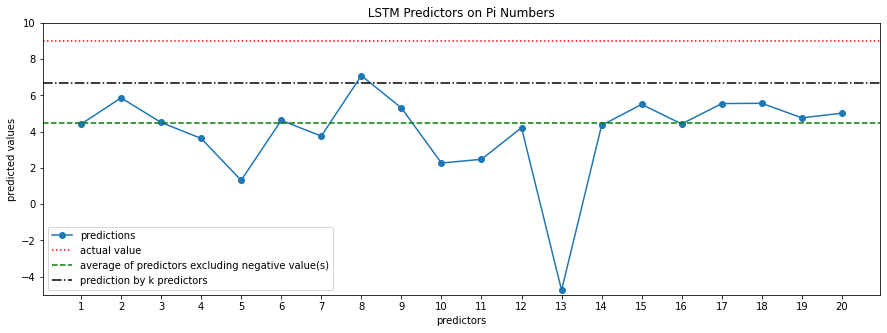

In [ ]:
plt.figure(figsize = (15, 5))
plt.plot(output_k_predictors_lstm_pi, label = 'predictions', marker = 'o' )
# specifying horizontal line type
plt.axhline(y = pi[:1000][-1], color = 'r', linestyle = 'dotted', label = 'actual value');
plt.axhline(np.mean(output_k_predictors_lstm_pi_positive), color = 'g', linestyle = 'dashed',\
            label = 'average of predictors excluding negative value(s)');
plt.axhline(yhat_k_predictors_pi_lstm, color = 'black', linestyle = 'dashdot',\
            label = 'prediction by k predictors');
plt.legend()
plt.ylabel('predicted values')
plt.xlabel('predictors')
plt.ylim((-5, 10))
plt.title(" LSTM Predictors on Pi Numbers ")
# define ticks
xticks = [str(i + 1) for i in range(20)]
plt.xticks(np.arange(0, 20), xticks);

## B. Covid data & LSTM

In [ ]:
data = pd.read_csv('Italia-positivi-giornaliero.csv')

In [ ]:
data_list = array(data.totale_positivi.values.tolist())

In [ ]:
split_data_covid = []

i = 1
predictors = 20 # number of  predictors
start = predictors 
seq = np.arange(start)
while i > 0 and start > 0:
    # print( "start: {}, i: {}, data:{}" .format(start, i, data_list[ start-1: -i] ) )
    split_data_covid.append(data_list[ start-1: -i])
    i+=1
    start-=1

In [ ]:
split_data_covid[0].shape

(620,)

In [ ]:
# split_data_covid

In [ ]:
output_k_predictors_lstm_covid = [] # list to save the final output of the k predictors.

In [ ]:
for i in seq:
    raw_seq = split_data_covid[i]
    # choose a number of time steps
    n_steps_in, n_steps_out = 20, i + 1
    # split into samples
    X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    n_features = 1
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    # define model
    # define model
    model = tf.keras.Sequential()
    model.add(layers.LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
    model.add(layers.Dense(n_steps_out))
    model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss='mse',
              metrics=[tf.keras.losses.MeanSquaredError()])
    # fit model
    model.fit(X, y, epochs=500, verbose=0)
    # demonstrate prediction
    x_input = split_data_covid[i][- n_steps_in:]
    x_input = x_input.reshape((1, n_steps_in, n_features))
    yhat = model.predict(x_input, verbose=0)
    
    output_k_predictors_lstm_covid.append(yhat[-1][-1])

In [ ]:
output_k_predictors_lstm_covid

[155366.48,
 158846.19,
 149288.06,
 162967.53,
 148799.11,
 152368.66,
 144160.95,
 136508.67,
 150660.23,
 135578.81,
 161547.27,
 124418.14,
 118657.7,
 118775.555,
 126114.11,
 98935.27,
 105995.21,
 123522.195,
 103485.92,
 102920.58]

In [ ]:
np.mean(output_k_predictors_lstm_covid)

133945.84

In [ ]:
# # take out only the positive values
# output_k_predictors_lstm_pi_positive = [i for i in output_k_predictors_lstm_pi if i > 0]
# output_k_predictors_lstm_pi_positive

In [ ]:
# np.mean([i for i in output_k_predictors_lstm_pi_positive if i > 0])

### Create, code, and train a deep model, a new MLP layer that takes as input the k predictions of your predictors and outputs one symbol. 

In [ ]:
# define input sequence
# raw_seq = sorted(output_k_predictors_lstm_covid)
raw_seq = output_k_predictors_lstm_covid
# choose a number of time steps
n_steps_in, n_steps_out = 3,  1
# split into samples
X, y = split_sequence(raw_seq,  n_steps_in, n_steps_out)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = tf.keras.Sequential()
model.add(layers.LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(layers.Dense(n_steps_out))

model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss='mse',
              metrics=[tf.keras.losses.MeanSquaredError()])
# fit model
model.fit(X, y, epochs=500, verbose=0)

In [ ]:
# demonstrate prediction
x_input = np.array(sorted(output_k_predictors_lstm_covid)[-3:])
# x_input = np.array(output_k_predictors_lstm_covid[-3:])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat_k_predictors_covid_lstm = model.predict(x_input, verbose=0)
print(yhat_k_predictors_covid_lstm)

[[153858.36]]


### Visualization of Results

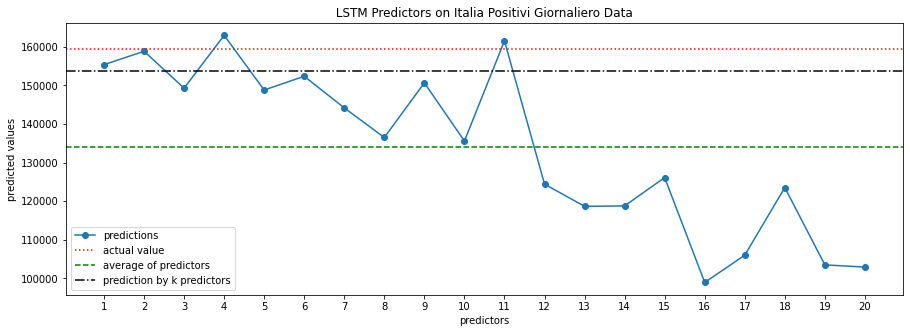

In [ ]:
plt.figure(figsize = (15, 5))
plt.plot(output_k_predictors_lstm_covid, label = 'predictions', marker = 'o' )
# specifying horizontal line type
plt.axhline(y = data_list[-1], color = 'r', linestyle = 'dotted', label = 'actual value');
plt.axhline(np.mean(output_k_predictors_lstm_covid), color = 'g', linestyle = 'dashed',\
            label = 'average of predictors');
plt.axhline(yhat_k_predictors_covid_lstm, color = 'black', linestyle = 'dashdot',\
            label = 'prediction by k predictors');
plt.legend()
plt.ylabel('predicted values')
plt.xlabel('predictors')
# plt.ylim((-5, 10))
plt.title(" LSTM Predictors on Italia Positivi Giornaliero Data ")
# define ticks
xticks = [str(i + 1) for i in range(20)]
plt.xticks(np.arange(0, 20), xticks);

# RNN

In [ ]:
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")

from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.optimizers import Adam

TensorFlow version: 2.9.2
Keras version: 2.9.0


## A. Covid data & RNN

In [ ]:
output_k_predictors_rnn_covid = [] # list to save the final output of the k predictors.

In [ ]:
for i in seq:
    raw_seq = split_data_covid[i]
    # choose a number of time steps
    n_steps_in, n_steps_out = 20, i + 1

    # split into samples
    X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)

    # reshape from [samples, timesteps] into [samples, timesteps, features]
    n_features = 1
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    
    # define model
    model = tf.keras.Sequential()
    model.add(layers.SimpleRNN(100, activation='relu', input_shape = (n_steps_in, n_features )))
    model.add(layers.Dense(n_steps_out))
    model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss='mse',
              metrics=[tf.keras.losses.MeanSquaredError()])
    
    # fit model
    model.fit(X, y, epochs=500, verbose=0)

    # demonstrate prediction
    x_input = split_data_covid[i][- n_steps_in:]
    x_input = x_input.reshape((1, n_steps_in, n_features))
    yhat = model.predict(x_input, verbose=0)
    
    output_k_predictors_rnn_covid.append(yhat[-1][-1])

In [ ]:
output_k_predictors_rnn_covid

[156320.4,
 155840.77,
 156294.66,
 160268.73,
 155701.36,
 151666.58,
 144023.88,
 125141.1,
 129977.81,
 153427.77,
 138143.22,
 144786.47,
 168606.9,
 133109.86,
 123793.625,
 137614.44,
 150641.8,
 128256.33,
 109090.62,
 109934.016]

In [ ]:
np.mean(output_k_predictors_rnn_covid)

141632.0

In [ ]:
# # take out only the positive values
# output_k_predictors_lstm_pi_positive = [i for i in output_k_predictors_lstm_pi if i > 0]
# output_k_predictors_lstm_pi_positive

In [ ]:
# np.mean([i for i in output_k_predictors_lstm_pi_positive if i > 0])

### Create, code, and train a deep model, a new MLP layer that takes as input the k predictions of your predictors and outputs one symbol. 

In [ ]:
# define input sequence
raw_seq = sorted(output_k_predictors_rnn_covid)
# raw_seq = output_k_predictors_rnn_covid
# choose a number of time steps
n_steps_in, n_steps_out = 3,  1
# split into samples
X, y = split_sequence(raw_seq,  n_steps_in, n_steps_out)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = tf.keras.Sequential()
model.add(layers.SimpleRNN(100, activation = 'relu', input_shape=(n_steps_in, n_features)))
model.add(layers.Dense(n_steps_out))

model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss='mse',
              metrics=[tf.keras.losses.MeanSquaredError()])
# fit model
model.fit(X, y, epochs=500, verbose=0)

In [ ]:
# demonstrate prediction
x_input = np.array(sorted(output_k_predictors_rnn_covid)[-3:])
# x_input = np.array(output_k_predictors_rnn_covid[-3:])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat_k_predictors_covid_rnn = model.predict(x_input, verbose=0)
print(yhat_k_predictors_covid_rnn)

[[169092.42]]


### Visualization of Results

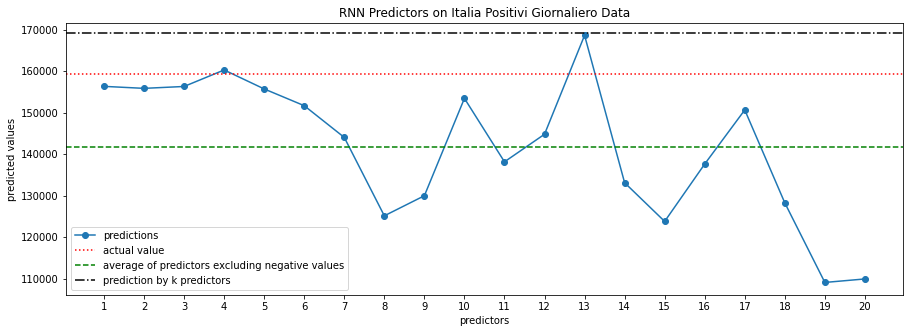

In [ ]:
plt.figure(figsize = (15, 5))
plt.plot(output_k_predictors_rnn_covid, label = 'predictions', marker = 'o' )
# specifying horizontal line type
plt.axhline(y = data_list[-1], color = 'r', linestyle = 'dotted', label = 'actual value');
plt.axhline(np.mean(output_k_predictors_rnn_covid), color = 'g', linestyle = 'dashed',\
            label = 'average of predictors excluding negative values');
plt.axhline(yhat_k_predictors_covid_rnn, color = 'black', linestyle = 'dashdot',\
            label = 'prediction by k predictors');
plt.legend()
plt.ylabel('predicted values')
plt.xlabel('predictors')
# plt.ylim((-5, 10))
plt.title("RNN Predictors on Italia Positivi Giornaliero Data")
# define ticks
xticks = [str(i + 1) for i in range(20)]
plt.xticks(np.arange(0, 20), xticks);

## B. Pi data & RNN

In [ ]:
# split_data_pi = split_data[:]

In [ ]:
output_k_predictors_rnn_pi = [] # list to save the final output of the k predictors.

In [ ]:
for i in seq:
    raw_seq = split_data_pi[i]
    # choose a number of time steps
    n_steps_in, n_steps_out = 20, i + 1
    # split into samples
    X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    n_features = 1
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    # define model
    # define model
    model = tf.keras.Sequential()
    model.add(layers.SimpleRNN(100, activation='relu', input_shape=(n_steps_in, n_features)))
    model.add(layers.Dense(n_steps_out))
    model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss='mse',
              metrics=[tf.keras.losses.MeanSquaredError()])
    # fit model
    model.fit(X, y, epochs=500, verbose=0)
    # demonstrate prediction
    x_input = split_data_pi[i][-n_steps_in:]
    x_input = x_input.reshape((1, n_steps_in, n_features))
    yhat = model.predict(x_input, verbose=0)
    
    output_k_predictors_rnn_pi.append(yhat[-1][-1])

In [ ]:
output_k_predictors_rnn_pi

[4.4037523,
 4.3405967,
 4.1592216,
 4268.1553,
 4.702572,
 4.2560663,
 1.0906875,
 2.9892662,
 4.1592193,
 0.6845672,
 0.21757317,
 3.833029,
 4.8533564,
 6.0739326,
 4.8404293,
 5.0996695,
 3.952223,
 5.468632,
 3.326451,
 5.62537]

In [ ]:
# take out only the values in close range to number 9
output_k_predictors_rnn_pi_clipped = [i for i in output_k_predictors_rnn_pi if i < 10]
output_k_predictors_rnn_pi_clipped

[4.4037523,
 4.3405967,
 4.1592216,
 4.702572,
 4.2560663,
 1.0906875,
 2.9892662,
 4.1592193,
 0.6845672,
 0.21757317,
 3.833029,
 4.8533564,
 6.0739326,
 4.8404293,
 5.0996695,
 3.952223,
 5.468632,
 3.326451,
 5.62537]

In [ ]:
np.mean(output_k_predictors_rnn_pi_clipped)

3.89877

### Create, code, and train a deep model, a new LSTM layer that takes as input the k predictions of your predictors and outputs one symbol. 

In [ ]:
# define input sequence
raw_seq = sorted(output_k_predictors_rnn_pi_clipped)
# raw_seq = output_k_predictors_rnn_pi
# choose a number of time steps
n_steps_in, n_steps_out = 3,  1
# split into samples
X, y = split_sequence(raw_seq,  n_steps_in, n_steps_out)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = tf.keras.Sequential()
model.add(layers.SimpleRNN(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(layers.Dense(n_steps_out))

model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss='mse',
              metrics=[tf.keras.losses.MeanSquaredError()])
# fit model
model.fit(X, y, epochs=500, verbose=0)

In [ ]:
# demonstrate prediction
x_input = np.array(sorted(output_k_predictors_rnn_pi_clipped)[-3:])
# x_input = np.array(output_k_predictors_rnn_pi[-3:])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat_k_predictors_pi_rnn = model.predict(x_input, verbose=0)
print(yhat_k_predictors_pi_rnn)

[[6.4201393]]


### Visualization of Results

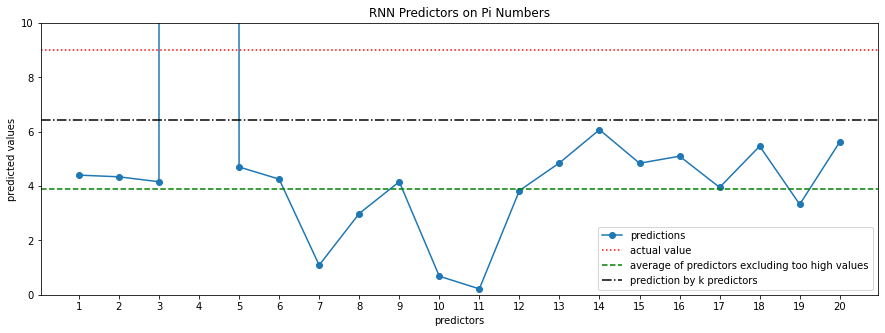

In [ ]:
plt.figure(figsize = (15, 5))
plt.plot(output_k_predictors_rnn_pi, label = 'predictions', marker = 'o' )
# specifying horizontal line type
plt.axhline(y = pi[:1000][-1], color = 'r', linestyle = 'dotted', label = 'actual value');
plt.axhline(np.mean(output_k_predictors_rnn_pi_clipped), color = 'g', linestyle = 'dashed',\
            label = 'average of predictors excluding too high values');
plt.axhline(yhat_k_predictors_pi_rnn, color = 'black', linestyle = 'dashdot',\
            label = 'prediction by k predictors');
plt.legend()
plt.ylabel('predicted values')
plt.xlabel('predictors')
plt.ylim((0, 10))
plt.title("RNN Predictors on Pi Numbers")
# define ticks
xticks = [str(i + 1) for i in range(20)]
plt.xticks(np.arange(0, 20), xticks);

# Aggregate Outputs.

For the covid and pi data, we combine the predictions from the three models and compare.

## COVID

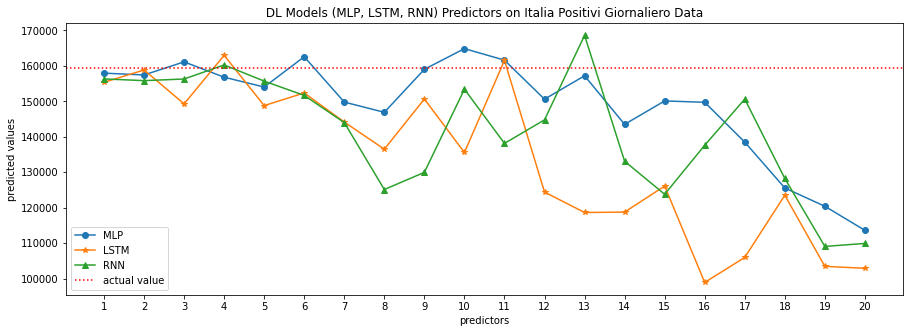

In [ ]:
plt.figure(figsize = (15, 5))
plt.plot(output_k_predictors, label = 'MLP', marker = 'o' )
plt.plot(output_k_predictors_lstm_covid, label = 'LSTM', marker = '*' )
plt.plot(output_k_predictors_rnn_covid, label = 'RNN', marker = '^' )
plt.axhline(y = data_list[-1], color = 'r', linestyle = 'dotted', label = 'actual value');
plt.xticks(np.arange(0, 20),xticks);
plt.legend()
plt.ylabel('predicted values')
plt.xlabel('predictors')
plt.title(" DL Models (MLP, LSTM, RNN) Predictors on Italia Positivi Giornaliero Data ");

## Pi

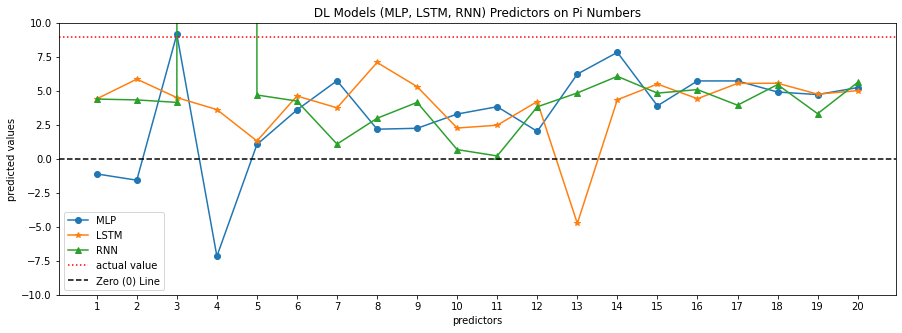

In [ ]:
plt.figure(figsize = (15, 5))
plt.plot(output_k_predictors_mlp_pi, label = 'MLP', marker = 'o' )
plt.plot(output_k_predictors_lstm_pi, label = 'LSTM', marker = '*' )
plt.plot(output_k_predictors_rnn_pi, label = 'RNN', marker = '^' )
plt.axhline(y = pi[:1000][-1], color = 'r', linestyle = 'dotted', label = 'actual value');
plt.axhline(y = 0, color = 'black', linestyle = 'dashed', label = 'Zero (0) Line');
plt.xticks(np.arange(0, 20),xticks);
plt.ylim((-10, 10))
plt.legend()
plt.ylabel('predicted values')
plt.xlabel('predictors')
plt.title(" DL Models (MLP, LSTM, RNN) Predictors on Pi Numbers ");